In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json
import zipfile
import pandas as pd
import graphviz
import pydot
# from google.colab import files

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)

2023-12-26 10:12:47.409041: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 10:12:47.604137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 10:12:47.604178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 10:12:47.631552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 10:12:47.693149: I tensorflow/core/platform/cpu_feature_guar

Python version: 3.11.0rc1
Tensorflow version: 2.15.0


In [2]:
 tf.config.list_physical_devices('GPU')

2023-12-26 10:12:50.458303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-12-26 10:12:50.495548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-26 10:12:50.495574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [4]:
def load_dataset(silent=False):
    dataset_file_names = [
        'recipes_raw_nosource_ar.json'
    ]

    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = os.path.join('/tf/recipce_AI/recipe_path_data', dataset_file_name)

        with open(dataset_file_path, 'r', encoding='utf-8') as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if not silent:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset
 

In [5]:
dataset_raw = load_dataset()  

/tf/recipce_AI/recipe_path_data/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless

In [6]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  39802


In [7]:



def cleaning_dataset(recipe, cleaned_titles):
    required_keys = ['title', 'ingredients', 'instructions']
    for key in required_keys:
        if key not in recipe or not recipe[key]:
            return False
        if type(recipe[key]) == list and len(recipe[key]) == 0:
            return False
    title = recipe['title'].lower()
    title_tuple = tuple(title)  # Convert title to tuple

    if title_tuple in cleaned_titles:
        return False

    cleaned_titles.add(title_tuple)
    return True



In [8]:
cleaned_titles = set()
dataset_validated = [recipe for recipe in dataset_raw if cleaning_dataset(recipe,cleaned_titles)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 39802
Dataset size AFTER validation 39057
Number of invalide recipes 745


In [9]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'


In [10]:
# Converts recipe object to string (sequence of characters) for later usage in RNN input.
def cooking_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [11]:
dataset_stringified = [cooking_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  39057


In [12]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

In [13]:
print(dataset_stringified[500])

📗 Savory Garlic Marinated Steaks

🥕

• 1/2 cup balsamic vinegar 
• 1/4 cup soy sauce 
• 3 tablespoons minced garlic 
• 2 tablespoons honey 
• 2 tablespoons olive oil 
• 2 teaspoons ground black pepper 
• 1 teaspoon Worcestershire sauce 
• 1 teaspoon onion powder 
• 1/2 teaspoon salt 
• 1/2 teaspoon liquid smoke flavoring 
• 1 pinch cayenne pepper 
• 2 (1/2 pound) rib-eye steaks 

📝

▪︎ In a medium bowl, mix the vinegar, soy sauce, garlic, honey, olive oil, ground black pepper, Worcestershire sauce, onion powder, salt, liquid smoke, and cayenne pepper.
▪︎ Place steaks in a shallow glass dish with the marinade, and turn to coat. For optimum flavor, rub the liquid into the meat. Cover, and marinate in the refrigerator for 1 to 2 days.
▪︎ Preheat grill for medium-high to high heat.
▪︎ Lightly oil the grill grate. Grill steaks 7 minutes per side, or to desired doneness. Discard leftover marinade.



In [14]:
#Recipes have different lengths. We need to have one hard-coded sequence length limit before feeding recipes sequences to RNN. 
#We need to find out what recipe length will cover most of recipe use-cases and at the same time we want to keep it as small 
#as possible for training performance.

recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

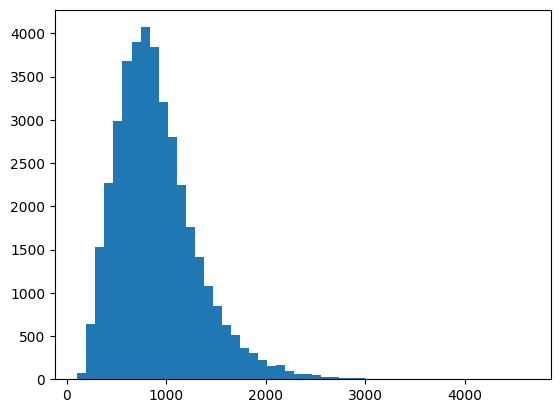

In [15]:
plt.hist(recipes_lengths, bins=50)
plt.show()

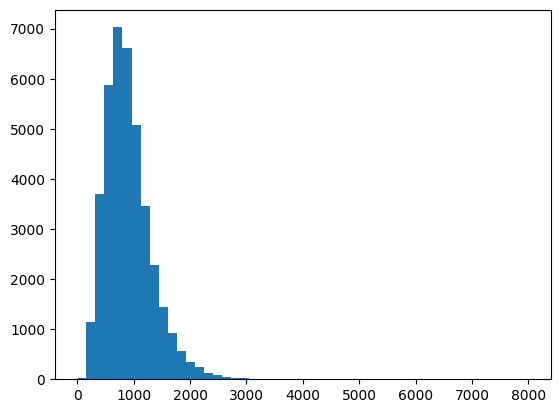

In [16]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [17]:
# Looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# We may try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 2000

# if DEBUG:
#     MAX_RECIPE_LENGTH = 500

In [18]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

In [19]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  39057
Dataset size AFTER filtering:  38318
Number of etiminated recipes:  739


In [20]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  38318


In [21]:
STOP_SIGN = '␣'

In [22]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [23]:
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

In [24]:
tokenizer.fit_on_texts(dataset_filtered)

In [25]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 38319,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 38318, " ": 5848239, "S": 81080, "l": 1168288, "o": 1958572, "w": 298098, "C": 89004, "k": 309244, "e": 3018509, "r": 1533670, "h": 837927, "i": 1539989, "c": 980243, "n": 1725269, "a": 1913745, "d": 956778, "D": 19325, "u": 924476, "m": 556952, "p": 891405, "g": 573768, "s": 1448701, "\\n": 736599, "\\ud83e\\udd55": 38318, "\\u2022": 344077, "4": 76978, ",": 372523, "b": 459181, "t": 1861956, "v": 224351, "2": 171672, "(": 64696, "1": 336040, "0": 61088, ".": 327776, "7": 18219, "5": 70270, ")": 64685, "f": 301669, "y": 181477, "\\ud83d\\udcdd": 38318, "\\u25aa": 124296, "\\ufe0e": 124296, "P": 69909, "6": 17335, "H": 14275, "A": 29666, "3": 76541, "R": 31484, "x": 84461, "/": 125366, "I": 28658, "L": 14602, "8": 20040, "9": 10715, "B": 49344, "M": 28367, "F": 35487, "j": 30739, "-": 52767, "W": 14567, "

In [26]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  113


In [27]:
print(tokenizer.index_word[6])
print(tokenizer.index_word[30])

n
/


In [28]:
tokenizer.word_index['d']

12

In [29]:
# For demo application we need to have an array of characters as vocabulary.
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in js_vocabulary])

['', ' ', 'e', 'o', 'a', 't', 'n', 'i', 'r', 's', 'l', 'c', 'd', 'u', 'p', 'h', '\n', 'g', 'm', 'b', ',', '•', '1', '.', 'k', 'f', 'w', 'v', 'y', '2', '/', '▪', '︎', 'C', 'x', 'S', '4', '3', '5', 'P', '(', ')', '0', '-', 'B', '📗', '🥕', '📝', 'F', ';', 'R', 'z', 'j', 'A', 'I', 'M', 'T', '8', 'D', 'q', '7', '6', 'G', 'L', 'W', 'H', "'", '9', 'O', '®', 'E', ':', 'J', 'N', 'V', 'K', 'U', 'Y', 'Q', '"', '!', 'Z', '&', '™', '%', '*', 'X', 'é', '<', '>', '+', '#', '=', '?', '½', '’', 'è', 'ñ', '°', '”', '\x96', '␣', '©', '[', ']', '$', '@', '{', '}', '–', 'à', 'â', 'á']


In [30]:
tokenizer.texts_to_sequences(['📗 yes'])

[[45, 1, 28, 2, 9]]

In [31]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [32]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [33]:
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 38318


In [34]:
print(dataset_vectorized[0][:10], '...')

[45, 1, 35, 10, 3, 26, 1, 33, 3, 3] ...


In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(dataset_vectorized)
max_index_example = np.max(padded_sequences)

print('max_index_example: ', max_index_example)

max_index_example:  112


In [36]:
recipe_sequence_to_string(dataset_vectorized[1])

📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



In [37]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 546
Recipe #2 length: 401
Recipe #3 length: 671
Recipe #4 length: 736
Recipe #5 length: 1518
Recipe #6 length: 740
Recipe #7 length: 839
Recipe #8 length: 667
Recipe #9 length: 1264
Recipe #10 length: 854


In [38]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [39]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [40]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [41]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [42]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)
print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(2001,), dtype=tf.int32, name=None)>


2023-12-26 10:12:59.413366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-26 10:12:59.413461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-26 10:12:59.413495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-26 10:12:59.661494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-26 10:12:59.661561: I external/local_xla/xla/stream_executor

In [43]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 45   1  35 ... 101 101 101] 



Stringified recipe:

📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [44]:
def split_input_target(recipe):   
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

# dataset_targeted = dataset.map(split_input_target)

# print(dataset_targeted)

# def split_input_target(recipe):
#     input_text = recipe[:-1]
#     target_text = recipe[1:]
    
#     # Ensure target_text is a tensor with an additional dimension
#     target_text = tf.expand_dims(target_text, -1)
    
#     return input_text, target_text

dataset_targeted = dataset.map(split_input_target)
print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [45]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified))) 



Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e s'


In [46]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))


Step  1
  input: 45 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 35 ('S')
Step  3
  input: 35 ('S')
  expected output: 10 ('l')
Step  4
  input: 10 ('l')
  expected output: 3 ('o')
Step  5
  input: 3 ('o')
  expected output: 26 ('w')
Step  6
  input: 26 ('w')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 33 ('C')
Step  8
  input: 33 ('C')
  expected output: 3 ('o')
Step  9
  input: 3 ('o')
  expected output: 3 ('o')
Step 10
  input: 3 ('o')
  expected output: 24 ('k')


In [47]:
print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [48]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  38318
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  113


In [49]:
# Batch size.
BATCH_SIZE = 32

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted \
    .shuffle(SHUFFLE_BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .repeat()

print(dataset_train)



<_RepeatDataset element_spec=(TensorSpec(shape=(32, 2000), dtype=tf.int32, name=None), TensorSpec(shape=(32, 2000), dtype=tf.int32, name=None))>


In [50]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 45   1  44 ... 101 101 101]
 [ 45   1  39 ... 101 101 101]
 [ 45   1  33 ... 101 101 101]
 ...
 [ 45   1  35 ... 101 101 101]
 [ 45   1  44 ... 101 101 101]
 [ 45   1  35 ... 101 101 101]], shape=(32, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  44   2 ... 101 101 101]
 [  1  39   7 ... 101 101 101]
 [  1  33   3 ... 101 101 101]
 ...
 [  1  35  10 ... 101 101 101]
 [  1  44   2 ... 101 101 101]
 [  1  35   5 ... 101 101 101]], shape=(32, 2000), dtype=int32)


In [51]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)


1/1 [==============================] - 0s 77ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[5 8 7 8 4 1 6 3]
 [7 2 4 2 5 3 2 6]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.04718179 -0.04465931 -0.01293183 -0.00315758 -0.0411256 ]
  [-0.02921771  0.01229727  0.00670003  0.01440426  0.0490559 ]
  [-0.03914871 -0.0243445  -0.0134518  -0.04609364  0.01846535]
  [-0.02921771  0.01229727  0.00670003  0.01440426  0.0490559 ]
  [ 0.01385417 -0.03893701  0.04093664 -0.03083023 -0.03207859]
  [ 0.02778218 -0.00232452 -0.0111407   0.00903925 -0.00213547]
  [ 0.02891413  0.03816811  0.0161065   0.01730621  0.03812561]
  [ 0.0145253  -0.0099897  -0.003488    0.04620108  0.02966226]]

 [[-0.03914871 -0.0243445  -0.0134518  -0.04609364  0.01846535]
  [ 0.04857992 -0.03659602  0.04168096  0.0451888  -0.03676478]
  [ 0.01385417 -0.03893701  0.04093664 -0.03083023 -0.03207859]
  [ 0.04857992 -0.03659602  0.04168096  0.0451888  -0.03676478]
  [ 0.04718179 -0.04465931 -0.01293183 

In [52]:
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.models.Sequential()
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=1e-3,
#         decay_steps=1000,
#         decay_rate=0.9,
#         staircase=True
#     )

#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


#     model.add(tf.keras.layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         batch_input_shape=[batch_size, None]
#     ))

#     model.add(tf.keras.layers.LSTM(
#         units=rnn_units, 
#         return_sequences=True,
#         stateful=True, 
#         recurrent_initializer=tf.keras.initializers.GlorotNormal(),
        
#         implementation=2
#     ))
    

#     model.add(tf.keras.layers.BatchNormalization())

#     model.add(tf.keras.layers.Dropout(0.2))

#     optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)

#     #model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

#     model.add(tf.keras.layers.Dense(vocab_size))
    
#     return model

# model = build_model(
#   vocab_size=VOCABULARY_SIZE,
#   embedding_dim=256,
#   rnn_units=1024,
#   batch_size=BATCH_SIZE
# )

# model.summary()

# import tensorflow as tf
# 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, LayerNormalization, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.callbacks import EarlyStopping

# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = Sequential()

#     # Learning rate schedule
#     lr_schedule = ExponentialDecay(
#         initial_learning_rate=1e-3,
#         decay_steps=1000,
#         decay_rate=0.9,
#         staircase=True
#     )

#     optimizer = Adam(learning_rate=lr_schedule, clipvalue=0.5)

#     model.add(Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         input_length=2000  # Assuming a sequence length of 500
#     ))

#     model.add(Bidirectional(LSTM(
#         units=rnn_units, 
#         return_sequences=True,
#         stateful=False,  # Set to False for non-stateful training
#         recurrent_initializer=tf.keras.initializers.GlorotNormal(),
#         implementation=2
#     )))

#     model.add(LayerNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(vocab_size, activation='softmax'))

#     # Compile the model
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', 'f1'])

#     return model

# # Assuming you have defined VOCABULARY_SIZE, BATCH_SIZE, X_train, y_train, X_val, y_val
# VOCABULARY_SIZE = 94
# BATCH_SIZE = 32

# model = build_model(
#     vocab_size=VOCABULARY_SIZE,
#     embedding_dim=256,
#     rnn_units=1024,
#     batch_size=BATCH_SIZE
# )

# target_example_batch = tf.random.uniform((BATCH_SIZE, 2000), maxval=94, dtype=tf.int32)
# example_batch_predictions = tf.random.normal((BATCH_SIZE, 2000, 94))

# # Print model summary
# model.summary()

# # Assuming you have defined X_train, y_train, X_val, y_val
# # Train the model with early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# model.fit(X_train, y_train, epochs=20, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, LayerNormalization, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.callbacks import EarlyStopping

# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.models.Sequential()
#     lr_schedule = ExponentialDecay(
#         initial_learning_rate=1e-3,
#         decay_steps=1000,
#         decay_rate=0.9,
#         staircase=True
#     )
#     model.add(tf.keras.layers.Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         batch_input_shape=[batch_size, None]
#     ))

#     model.add(Bidirectional(LSTM(
#         units=rnn_units, 
#         return_sequences=True,
#         stateful=True,  # Set to False for non-stateful training
#         recurrent_initializer=tf.keras.initializers.GlorotNormal(),
#         implementation=2
#     )))


#     model.add(Dense(vocab_size, activation='softmax'))
#     model.add(LayerNormalization())
#     model.add(Dropout(0.2))
#     optimizer = Adam(learning_rate=lr_schedule, clipvalue=0.5)
#     # model.compile(optimizer=optimizer, 
#     #           loss='sparse_categorical_crossentropy',
#     #           metrics=['accuracy', 'precision', 'recall', 'f1']
#     #          )
    
#     return model
# VOCABULARY_SIZE = 113
# BATCH_SIZE = 32
# model = build_model(
#     vocab_size=VOCABULARY_SIZE,
#     embedding_dim=256,
#     rnn_units=1024,
#     batch_size=BATCH_SIZE
# )

# model.summary()
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
    vocab_size=VOCABULARY_SIZE,
    embedding_dim=256,
    rnn_units=1024,
    batch_size=BATCH_SIZE
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (32, None, 256)           28928     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 113)           115825    
                                                                 
Total params: 5391729 (20.57 MB)
Trainable params: 5391729 (20.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
    
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_names=True,
        to_file='model.png'
    )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [54]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


2023-12-26 10:13:01.004275: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


(32, 2000, 113) # (batch_size, sequence_length, vocab_size)


In [55]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 4.0740119e-03  5.4946225e-03 -1.0465346e-03 -2.9471659e-03
  2.6832102e-03 -6.5123863e-03 -6.7115789e-03  2.6211794e-03
  3.8477166e-03 -1.0411129e-03 -7.2265766e-03  9.4367901e-04
 -3.3513235e-03  3.1113422e-03 -2.2653416e-03 -3.4869093e-04
 -2.0187921e-03  2.6271250e-03  4.4936134e-04 -3.6010693e-03
  2.1743191e-04  1.7120971e-04  1.9233532e-03  4.4946340e-03
 -1.0052264e-03  3.7629937e-03  2.2383782e-03  1.5016096e-03
 -4.9881223e-03  3.8539011e-03 -5.8299134e-04 -2.3029649e-03
  6.1773136e-03 -5.2049877e-03 -7.7725283e-04 -1.2968812e-03
 -3.2332365e-04  4.9897289e-04 -2.8181486e-03 -2.2072769e-03
  1.2284329e-03 -1.8991624e-03  1.8855419e-04 -1.7020168e-03
  2.2655986e-03 -7.4530952e-04 -1.5921375e-03  2.5348598e-03
  2.4484482e-03 -1.0197146e-03 -5.6827766e-06 -9.1437553e-04
 -5.1540197e-03  3.8917162e-04 -3.2070972e-04  4.9817180e-03
 -7.2639934e-03  1.7299826e-03  2.1776871e-03 -1.4672335e-03
  5.1971213e-03 -

In [56]:
# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0"
# (element with index 0) is low but the probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
]

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 0 2 2 0]], shape=(1, 5), dtype=int64)


In [57]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape


(2000,)

In [58]:
sampled_indices[:100]

array([ 96,  97,  92,   3,   2,  40,  92,  71, 105,  80, 108,  49,  24,
        90,   2,  41,  67,  48,  22,  16,  85,  21,  48,  79,  80,  23,
       103,  72,  29,  89,  89,  28,   7,  29,  84,  18,  32,  68,  56,
        77,   2,  62,  90,  26,   0,  15,  70,  37,  60,  90,  36, 110,
        82,  91,  30,  40,  41, 107, 100,  97,  82,  47, 110,  23,  90,
         4, 110,  16,  54,  89,  33,  31, 109,  11,   0,  54,  46,   6,
         3,  70,  88, 104, 100,  36,  49,  41,  60,  91,  14,  44,  22,
        29, 100,  42,  40,  30,  45,  83,  57, 107])

In [59]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]])))) 


Input:
 "📗   B o b ' s   A w e s o m e   L a s a g n a \n \n 🥕 \n \n •   8   o u n c e s   l a s a g n a   n o o"

Next char prediction:
 'è ñ = o e ( = : $ ! } ; k + e ) 9 F 1 \n * • F " ! . [ J 2 > > y i 2 % m ︎ O T Y e G + w h E 3 7 +'


In [60]:
    print("Labels shape: ", target_example_batch.shape)
    print("Logits shape: ", example_batch_predictions.shape)


Labels shape:  (32, 2000)
Logits shape:  (32, 2000, 113)


In [61]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).



def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=labels,
        y_pred=logits,
        from_logits=True
    )
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean()) 


Prediction shape:  (32, 2000, 113)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (32, 2000)
scalar_loss:       4.7292995


In [62]:
# tf.experimental.numpy.experimental_enable_numpy_behavior()
# l = example_batch_predictions.reshape()
# print(l)

In [63]:

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss,
    metrics=['accuracy'] 
)


In [64]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)


In [65]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)


In [66]:
EPOCHS = 1500
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 50

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)


EPOCHS:           1500
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  50


In [ ]:
val_predictions = [] 
val_targets = []

for x_val, y_val in dataset_train:
    predictions = model(x_val)
    predictions = tf.argmax(predictions, axis=-1)
    val_predictions.extend(predictions.numpy())
    val_targets.extend(y_val.numpy())

# Calculate precision
precision = precision_score(val_targets, val_predictions, average='weighted')
print(f'Precision: {precision:.4f}')

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(val_targets, val_predictions)
print('Confusion Matrix:')
print(conf_matrix)

In [68]:
# evaluate_model(model, dataset_test)

In [69]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

# Access the training history, including accuracy
loss_values = history.history['loss']
accuracy_values = history.history['accuracy'] 

Epoch 2/1500


2023-12-26 10:13:03.210572: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f14cd64bed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-26 10:13:03.210600: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2023-12-26 10:13:03.222089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703585583.297447    2945 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 21s 372ms/step - loss: 1.7415 - accuracy: 0.6139
Epoch 3/1500
50/50 [==============================] - 18s 365ms/step - loss: 1.2794 - accuracy: 0.6603
Epoch 4/1500
50/50 [==============================] - 18s 365ms/step - loss: 1.0009 - accuracy: 0.7163
Epoch 5/1500
50/50 [==============================] - 18s 365ms/step - loss: 0.8742 - accuracy: 0.7465
Epoch 6/1500
50/50 [==============================] - 18s 365ms/step - loss: 0.7914 - accuracy: 0.7703
Epoch 7/1500
50/50 [==============================] - 18s 364ms/step - loss: 0.6984 - accuracy: 0.7975
Epoch 8/1500
50/50 [==============================] - 18s 364ms/step - loss: 0.6400 - accuracy: 0.8159
Epoch 9/1500
50/50 [==============================] - 18s 363ms/step - loss: 0.5937 - accuracy: 0.8283
Epoch 10/1500
50/50 [==============================] - 18s 368ms/step - loss: 0.5426 - accuracy: 0.8429
Epoch 11/1500
50/50 [==============================] - 18s 369ms/step - loss: 0.5042 

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


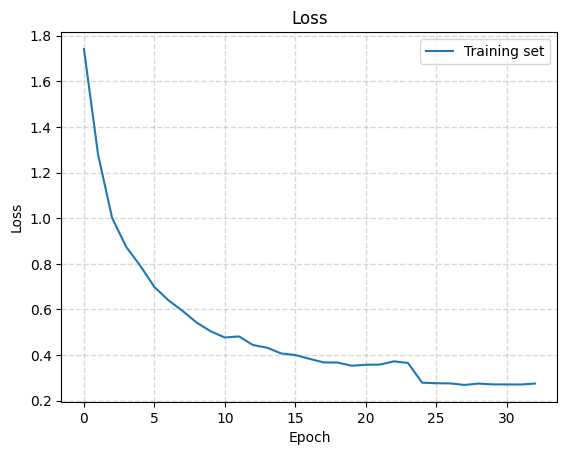

In [70]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [71]:
# accuracy = history.history['accuracy'][-1]
# print(f'Final Training Accuracy: {accuracy * 100:.2f}%')
loss, accuracy = model.evaluate(dataset_train, steps=STEPS_PER_EPOCH)

# # print(f'Loss: {loss}, Accuracy: {accuracy * 100:.2f}%')


print(f'Loss: {loss},Accuracy: {accuracy * 100:.2f}%')

50/50 [==============================] - 8s 158ms/step - loss: 0.2599 - accuracy: 0.9204
Loss: 0.2599284052848816,Accuracy: 92.04%


In [72]:
# val_data = list(dataset_train.as_numpy_iterator())
# val_inputs = np.array([x for x, y in val_data])
# val_targets = np.argmax(np.array([y for x, y in val_data]), axis=-1)

# val_predict = np.argmax(model.predict(val_inputs), axis=-1)

# # Compute precision
# precision = precision_score(val_targets, val_predict, average='weighted')

# # Print or use the precision value as needed
# print(f'Precision: {precision:.4f}')

# import numpy as np
# from sklearn.metrics import precision_score, confusion_matrix
# val_predictions = []
# val_targets = []
# for x_val, y_val in dataset_train:
#     val_predictions.extend(np.argmax(model.predict(x_val), axis=-1))
#     val_targets.extend(y_val.numpy())

# # Calculate precision
# precision = precision_score(val_targets, val_predictions, average='weighted')
# print(f'Precision: {precision:.4f}')

# # Calculate and display confusion matrix
# conf_matrix = confusion_matrix(val_targets, val_predictions)
# print('Confusion Matrix:')
# print(conf_matrix)

# val_predictions = [] 
# val_targets = []

# for x_val, y_val in dataset_train:
#     predictions = model(x_val)
#     predictions = tf.argmax(predictions, axis=-1)
#     val_predictions.extend(predictions.numpy())
#     val_targets.extend(y_val.numpy())

# # Calculate precision
# precision = precision_score(val_targets, val_predictions, average='weighted')
# print(f'Precision: {precision:.4f}')

# # Calculate and display confusion matrix
# conf_matrix = confusion_matrix(val_targets, val_predictions)
# print('Confusion Matrix:')
# print(conf_matrix)

In [73]:
history.history

{'loss': [1.741512417793274,
  1.279423475265503,
  1.0008916854858398,
  0.8742000460624695,
  0.791394054889679,
  0.6984485387802124,
  0.639983057975769,
  0.5936669111251831,
  0.5425500273704529,
  0.5042470693588257,
  0.477173388004303,
  0.4819999933242798,
  0.44412773847579956,
  0.432580828666687,
  0.40729331970214844,
  0.4004534184932709,
  0.38388633728027344,
  0.3681653141975403,
  0.36740371584892273,
  0.35352447628974915,
  0.3578071892261505,
  0.35853341221809387,
  0.3727625608444214,
  0.3654598295688629,
  0.27925124764442444,
  0.27680638432502747,
  0.27598363161087036,
  0.2694512605667114,
  0.27522239089012146,
  0.2718459963798523,
  0.27154263854026794,
  0.2713594436645508,
  0.2752751410007477],
 'accuracy': [0.613940954208374,
  0.6603356003761292,
  0.7163100242614746,
  0.7465137243270874,
  0.7703081369400024,
  0.7975393533706665,
  0.8159199953079224,
  0.8283431529998779,
  0.8428884148597717,
  0.8539112210273743,
  0.862202525138855,
  0.8602

In [74]:
# simplified_batch_size = 1
# # Length of the vocabulary in chars.
# vocab_size = VOCABULARY_SIZE

# # The embedding dimension.
# embedding_dim = 256

# # Number of RNN units.
# rnn_units = 1024

# model_simplified = build_model(vocab_size, embedding_dim, rnn_units, simplified_batch_size)
# model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
# model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

# model_simplified.summary()

simplified_batch_size = 1
vocab_size = VOCABULARY_SIZE
embedding_dim = 256
rnn_units = 1024

model_simplified = build_model(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

# Load the weights from the latest checkpoint
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

# Print the model summary
model_simplified.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            28928     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 113)            115825    
                                                                 
Total params: 5391729 (20.57 MB)
Trainable params: 5391729 (20.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
model_simplified.input_shape

(1, None)

In [76]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [77]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = [ 'mushroom']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

In [78]:
generate_combinations(model_simplified)

Attempt: "mushroom" + 1.0
-----------------------------------
📗 mushroomDVkm}supers and marinated over the mozzarella chips 
• salt to taste (optional) 
• 1 teaspoon salt 
• 1 teaspoon ground black pepper 
• 1 teaspoon Chyes 

📝

▪︎ Cook the shredded chicken breasts in boiling water if desired and ground the mizza mixture. Season with the yralkon ground lime rice. Spoon into 15 pieck before serving.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [79]:


# Print or use the history values as needed
print(f'Loss values: {loss_values}')
print(f'Accuracy values: {accuracy_values}')


Loss values: [1.741512417793274, 1.279423475265503, 1.0008916854858398, 0.8742000460624695, 0.791394054889679, 0.6984485387802124, 0.639983057975769, 0.5936669111251831, 0.5425500273704529, 0.5042470693588257, 0.477173388004303, 0.4819999933242798, 0.44412773847579956, 0.432580828666687, 0.40729331970214844, 0.4004534184932709, 0.38388633728027344, 0.3681653141975403, 0.36740371584892273, 0.35352447628974915, 0.3578071892261505, 0.35853341221809387, 0.3727625608444214, 0.3654598295688629, 0.27925124764442444, 0.27680638432502747, 0.27598363161087036, 0.2694512605667114, 0.27522239089012146, 0.2718459963798523, 0.27154263854026794, 0.2713594436645508, 0.2752751410007477]
Accuracy values: [0.613940954208374, 0.6603356003761292, 0.7163100242614746, 0.7465137243270874, 0.7703081369400024, 0.7975393533706665, 0.8159199953079224, 0.8283431529998779, 0.8428884148597717, 0.8539112210273743, 0.862202525138855, 0.8602637648582458, 0.8714022040367126, 0.874671220779419, 0.8815175294876099, 0.8835

In [80]:
tf.keras.backend.clear_session()

tf.debugging.enable_check_numerics


<function tensorflow.python.debug.lib.check_numerics_callback.enable_check_numerics(stack_height_limit=30, path_length_limit=50)>

2023-12-26 10:28:40.281170: I external/local_xla/xla/stream_executor/stream.cc:1986] INTERNAL: Unknown error
2023-12-26 10:28:40.281218: I external/local_xla/xla/stream_executor/stream.cc:1990] [stream=0x852d730,impl=0x2484d2f0] INTERNAL: stream did not block host until done; was already in an error state


InternalError: stream did not block host until done; was already in an error state

In [85]:

val_predict = np.argmax(model.predict(dataset_train), axis=-1)
val_targ = dataset_train.map(lambda x, y: y)
precision = precision_score(val_targ, val_predict, average='weighted')
recall = recall_score(val_targ, val_predict, average='weighted')
f1 = f1_score(val_targ, val_predict, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).